In [14]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.framework import ops
import pandas as pd
import matplotlib.pyplot as plt
from tf_utils import load_dataset, random_mini_batches, convert_to_one_hot, predict
import time

%matplotlib inline

In [15]:
# download data
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

# print(train_data.columns[:12])
# print(train_data)
print(test_data)
# train_data.describe()
# test_data.describe()

     PassengerId  Pclass                                               Name  \
0            892       3                                   Kelly, Mr. James   
1            893       3                   Wilkes, Mrs. James (Ellen Needs)   
2            894       2                          Myles, Mr. Thomas Francis   
3            895       3                                   Wirz, Mr. Albert   
4            896       3       Hirvonen, Mrs. Alexander (Helga E Lindqvist)   
5            897       3                         Svensson, Mr. Johan Cervin   
6            898       3                               Connolly, Miss. Kate   
7            899       2                       Caldwell, Mr. Albert Francis   
8            900       3          Abrahim, Mrs. Joseph (Sophie Halaut Easu)   
9            901       3                            Davies, Mr. John Samuel   
10           902       3                                   Ilieff, Mr. Ylio   
11           903       1                         Jon

In [3]:
# 分析数据
# PassengerId => 乘客ID
# Pclass => 乘客等级(1/2/3等舱位)
# Name => 乘客姓名
# Sex => 性别
# Age => 年龄
# SibSp => 堂兄弟/妹个数
# Parch => 父母与小孩个数
# Ticket => 船票信息
# Fare => 票价
# Cabin => 客舱
# Embarked => 登船港口
train_data.info()
# data = train_data['Fare'].fillna(train_data['Fare'].median())
# print(raw_data['Fare'])
# print(data)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [4]:
# # Pclass => 乘客等级(1/2/3等舱位)
# print (train_data[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean())

# print (train_data[["Sex", "Survived"]].groupby(['Sex'], as_index=False).mean())
# # 将sibsp,parch合并成一个特征，主要是看是否是一个人
# train_data['FamilySize'] = train_data['SibSp'] + train_data['Parch'] + 1 
# print (train_data[['FamilySize', 'Survived']].groupby(['FamilySize'], as_index=False).mean())
# train_data['IsAlone'] = 0
# train_data.loc[train_data['FamilySize'] == 1, 'IsAlone'] = 1
# print (train_data[['IsAlone', 'Survived']].groupby(['IsAlone'], as_index=False).mean())
# # 终点站这个特征有C，Q，S三个值，这个特征有缺失值，将其填充为S。同样需要进行映射为0,1,2。
# train_data['Embarked'] = train_data['Embarked'].fillna('S')
# print (train_data[['Embarked', 'Survived']].groupby(['Embarked'], as_index=False).mean())
# # 船票票价这个特征是一个连续型数据，我们对其进行处理平分为四等分，后面分别映射为0，1，2，3。
# # raw_data['Fare'] = raw_data['Fare'].fillna(raw_data['Fare'].median())
# train_data['CategoricalFare'] = pd.qcut(train_data['Fare'], 4)
# print (train_data[['CategoricalFare', 'Survived']].groupby(['CategoricalFare'], as_index=False).mean())
# # 年龄这个特征同样也是连续型数据，而且缺失值比较多，我们可以将缺失值当做一个类别进行处理，其他的年龄可以等分为五种类别，在后续的数据清理中处理，这里就总共有六种类别
# age_null_count = train_data['Age'].isnull().sum()
# averge_age = train_data['Age'].sum() / (891-age_null_count)
# # 将为空的年龄填成平均年龄
# train_data['Age'] = train_data['Age'].fillna(averge_age)
# # print(raw_data['Age'])
# # print(age_not_null_sum / (891-age_null_count))
# # print(raw_data['Survived'][raw_data['Age'].isnull()])
# train_data['CategoricalAge'] = pd.cut(train_data['Age'], 5)
# print (train_data[['CategoricalAge', 'Survived']].groupby(['CategoricalAge'], as_index=False).mean())

def processing_data(dataset):
# 处理数据
#     性别映射为0，1
    dataset['Sex'] = dataset['Sex'].replace(['male', 'female'],[0, 1])
    
    # 将SibSp和Parch两个合并为一个特征，家庭大小，并同时扩展为是否独自一人的特征
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1
    
#     终点站，缺失值补充为S，有三种类型 
    dataset['Embarked'] = dataset['Embarked'].fillna('S')
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
    
    # 票价，0，1，2，3四种
    dataset['Fare'] = dataset['Fare'].fillna(dataset['Fare'].median())
    dataset.loc[dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare'] = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)
    
    # 年龄，缺失值为类别5
    dataset.loc[ dataset['Age'] <= 16, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age']                           = 4
    dataset.loc[ dataset['Age'].isnull(), 'Age']                       = 5
    dataset['Age'] = dataset['Age'].astype(int)
    
    #replace missing value with U0
    dataset['Cabin'] = dataset.Cabin.fillna('U0') # dataset.Cabin[dataset.Cabin.isnull()]='U0'
    
    drop_elements = ['PassengerId', 'Name', 'Ticket', 'SibSp','Parch']
    dataset = dataset.drop(drop_elements, axis = 1)
    
    model_data = dataset[['Pclass', 'Sex', 'Age', 'Fare', 'Embarked', 'FamilySize', 'IsAlone']]
#     pre_treatment_data = model_data.apply(lambda x: (x - np.mean(x)) / (np.max(x) - np.min(x)), axis=0)
    data = model_data.apply(lambda x: (x - np.mean(x)) / (np.max(x) - np.min(x)), axis=0)

    return data;

In [5]:
# print(processing_data(train_data))

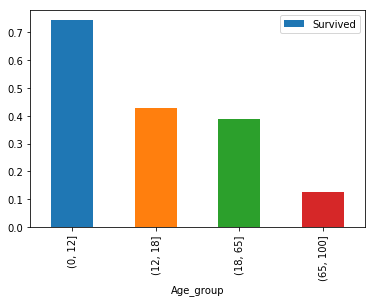

In [6]:
# 画图
# train_data.groupby(['Sex','Survived'])['Survived'].count()
train_data[['Sex','Survived']].groupby(['Sex']).mean().plot.bar()
# train_data.groupby(['Pclass','Survived'])['Pclass'].count()
# train_data[['Pclass','Survived']].groupby(['Pclass']).mean().plot.bar()

bins = [0, 12, 18, 65, 100]
train_data['Age_group'] = pd.cut(train_data['Age'], bins)
train_data.groupby('Age_group')['Survived'].mean().plot(kind = 'bar')


In [7]:
# GRADED FUNCTION: create_placeholders

def create_placeholders(n_x, n_y):
    """
    Creates the placeholders for the tensorflow session.
    
    Arguments:
    n_x -- scalar, size of an image vector 
    n_y -- scalar, number of classes 
    
    Returns:
    X -- placeholder for the data input, of shape [n_x, None] and dtype "float"
    Y -- placeholder for the input labels, of shape [n_y, None] and dtype "float"
    
    Tips:
    - You will use None because it let's us be flexible on the number of examples you will for the placeholders.
      In fact, the number of examples during test/train is different.
    """

    ### START CODE HERE ### 
    X = tf.placeholder(shape=[n_x, None], dtype=tf.float32)
    Y = tf.placeholder(shape=[n_y, None], dtype=tf.float32)
    ### END CODE HERE ###
    
    return X, Y

In [8]:
# GRADED FUNCTION: initialize_parameters

def initialize_parameters():
    """
    Initializes parameters to build a neural network with tensorflow. 
    Returns:
    parameters -- a dictionary of tensors containing W1, b1, W2, b2, W3, b3
    """
    
    ### START CODE HERE ### (approx. 6 lines of code)
    W1 = tf.Variable(tf.random_normal([4, 7]), name='W1')
    b1 = tf.Variable(tf.random_normal([4, 1]), name='b1')

    W2 = tf.Variable(tf.random_normal([10, 4]), name='W2')
    b2 = tf.Variable(tf.random_normal([10, 1]), name='b2')

    W3 = tf.Variable(tf.random_normal([1, 10]), name='W3')
    b3 = tf.Variable(tf.random_normal([1, 1]), name='b3')
    ### END CODE HERE ###

    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2,
                  "W3": W3,
                  "b3": b3}
    
    return parameters

In [9]:
# GRADED FUNCTION: forward_propagation

def forward_propagation(X, parameters):
    """
    Implements the forward propagation for the model: LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SOFTMAX
    
    Arguments:
    X -- input dataset placeholder, of shape (input size, number of examples)
    parameters -- python dictionary containing your parameters "W1", "b1", "W2", "b2", "W3", "b3"
                  the shapes are given in initialize_parameters

    Returns:
    Z3 -- the output of the last LINEAR unit
    """
    
    # Retrieve the parameters from the dictionary "parameters" 
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']
    
    ### START CODE HERE ### (approx. 5 lines)              # Numpy Equivalents:
    Z1 = tf.add(tf.matmul(W1, X), b1)                                            # Z1 = np.dot(W1, X) + b1
    A1 = tf.nn.relu(Z1)                                              # A1 = relu(Z1)
    Z2 = tf.add(tf.matmul(W2, A1), b2)                                              # Z2 = np.dot(W2, a1) + b2
    A2 = tf.nn.relu(Z2)                                              # A2 = relu(Z2)
    Z3 = tf.add(tf.matmul(W3, A2), b3)                                              # Z3 = np.dot(W3,Z2) + b3
    ### END CODE HERE ###
    
    return Z3

In [10]:
# GRADED FUNCTION: compute_cost 

def compute_cost(Z3, Y):
    """
    Computes the cost
    
    Arguments:
    Z3 -- output of forward propagation (output of the last LINEAR unit), of shape (6, number of examples)
    Y -- "true" labels vector placeholder, same shape as Z3
    
    Returns:
    cost - Tensor of the cost function
    """
    
    # to fit the tensorflow requirement for tf.nn.softmax_cross_entropy_with_logits(...,...)
#     logits = tf.transpose(Z3)
#     labels = tf.transpose(Y)
    
#     print(logits)
#     print(labels)

#     print(Z3.shape)
#     print(Y.shape)
    
    ### START CODE HERE ### (1 line of code)
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits = Z3, labels = Y))
    ### END CODE HERE ###
    
    return cost

In [11]:
def model(X_train, Y_train, learning_rate = 0.0001,
          num_epochs = 1500, minibatch_size = 32, print_cost = True):
    """
    Implements a three-layer tensorflow neural network: LINEAR->RELU->LINEAR->RELU->LINEAR->SOFTMAX.
    
    Arguments:
    X_train -- training set, of shape (input size = 12288, number of training examples = 1080)
    Y_train -- test set, of shape (output size = 6, number of training examples = 1080)
    X_test -- training set, of shape (input size = 12288, number of training examples = 120)
    Y_test -- test set, of shape (output size = 6, number of test examples = 120)
    learning_rate -- learning rate of the optimization
    num_epochs -- number of epochs of the optimization loop
    minibatch_size -- size of a minibatch
    print_cost -- True to print the cost every 100 epochs
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
#     print('X shape is: ', X_train.shape)
#     print('Y shape is: ', Y_train.shape)
    (n_x, m) = X_train.shape                          # (n_x: input size, m : number of examples in the train set)
#     n_y = Y_train.shape[0]                            # n_y : output size
    costs = []       # To keep track of the cost
    
    # Create Placeholders of shape (n_x, n_y)
    ### START CODE HERE ### (1 line)
    X = tf.placeholder(dtype = np.float32, shape = [n_x, None])
    Y = tf.placeholder(dtype = np.float32, shape = [1, None])  
#     print(X.shape[1])
    ### END CODE HERE ###

    # Initialize parameters
    ### START CODE HERE ### (1 line)
    parameters = initialize_parameters()
#     print(parameters)
    ### END CODE HERE ###
    
    # Forward propagation: Build the forward propagation in the tensorflow graph
    ### START CODE HERE ### (1 line)
    Z3 = forward_propagation(X, parameters)
    ### END CODE HERE ###
    
    # Cost function: Add cost function to tensorflow graph
    ### START CODE HERE ### (1 line)
    cost = compute_cost(Z3, Y)
    ### END CODE HERE ###
    
    # Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer.
    ### START CODE HERE ### (1 line)
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)
    ### END CODE HERE ###
    
    # Initialize all the variables
    init = tf.global_variables_initializer()

    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:
        
        # Run the initialization
        sess.run(init)
        
        # Do the training loop
        for epoch in range(num_epochs):

            epoch_cost = 0.                       # Defines a cost related to an epoch
            print(minibatch_size)
            print(m)
            print(m // minibatch_size)
            num_minibatches = m // minibatch_size # number of minibatches of size minibatch_size in the train set

        
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size)
            
            for minibatch in minibatches:

                # Select a minibatch
                (minibatch_X, minibatch_Y) = minibatch
                
                # IMPORTANT: The line that runs the graph on a minibatch.
                # Run the session to execute the "optimizer" and the "cost", the feedict should contain a minibatch for (X,Y).
                ### START CODE HERE ### (1 line)
                _ , minibatch_cost = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y})
                ### END CODE HERE ###
                
                epoch_cost += minibatch_cost / num_minibatches

            # Print the cost every epoch
            if print_cost == True and epoch % 100 == 0:
                print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
            if print_cost == True and epoch % 5 == 0:
                costs.append(epoch_cost)
                
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()
        # print('Total time: {0} seconds'.format(time.time() - start_time))
        print('Optimization Finished!')
        # lets save the parameters in a variable
        parameters = sess.run(parameters)
        print ("Parameters have been trained!")
        
        # Calculate the correct predictions
        correct_prediction = tf.equal(tf.argmax(Z3), tf.argmax(Y))
        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        print ("Train Accuracy:", accuracy.eval({X: X_train, Y: Y_train.T}))
        print ("-------------Done----------------------")

        return parameters

In [12]:
# preTreatmentData(train_data)
# parameters = model(train_data, train_label)
# data = processing_data(train_data)
# train_label = train_data['Survived']

# print(data.shape)
# print(train_label.shape)
# model(np.transpose(data.values), train_label.values.reshape((1, -1)))
# train_data.info()
# print(preTreatmentData(train_data))


In [13]:
# test_set = processing_data(test_data)
# test_label = test_data['Survived']
print(test_data.info())
print(test_data.shape)
# model(np.transpose(test_set.values), test_label.values.reshape((1, -1)))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB
None
(418, 11)
